# 机器也懂情感：文本分类

在本课中，我们通过抓取京东商场上面的评论形成我们的语料。然后，我们训练一个模型来对这些评论进行分类，分为正面的评论和负面的评论。

首先，我们展示了如何写一个简单的爬虫程序从网上扒文章；

其次，我们设计了一个简单的前馈网络，利用词袋模型获得每一个评论的向量表示，并输入进前馈网络得到很好的分类效果，我们还对这个网络进行了简单的剖析。

然后，我们尝试了两种RNN网络，一种是普通的RNN，另一种是LSTM。本程序展示了它们在处理同样的文本分类问题上的用法

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [2]:
# 导入程序所需要的程序包

#抓取网页内容用的程序包
import json
import requests

#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable

# 自然语言处理相关的包
import re #正则表达式的包
import jieba #结巴分词包
from collections import Counter #搜集器，可以让统计词频更简单

#绘图、计算用的程序包
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/Users/tradeshift/Workspace/deep_learning_tutorial/p3ml-venv/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## 一、数据处理

我们的数据来源于京东上的商品评论，每一条评论都会配合有一个评分。我们通过调用接口将相应的参数传入进去就可以得到评论。

根据评分的高低，我们可以划分成正向和负向两组标签

### 1、从京东上抓取评论数据

In [2]:
# 在指定的url处获得评论
def get_comments(url):
    comments = []
    # 打开指定页面
    resp = requests.get(url)
    resp.encoding = 'gbk'
    
    #如果200秒没有打开则失败
    if resp.status_code != 200:
        return []
    
    #获得内容
    content = resp.text
    if content:
        #获得（）括号中的内容
        ind = content.find('(')
        s1 = content[ind+1:-2]
        try:
            #尝试利用jason接口来读取内容，并做jason的解析
            js = json.loads(s1)
            #提取出comments字段的内容
            comment_infos = js['comments']
        except:
            print('error')
            return([])
        
        #对每一条评论进行内容部分的抽取
        for comment_info in comment_infos:
            comment_content = comment_info['content']
            str1 = comment_content + '\n'
            comments.append(str1)
    return comments

good_comments = []

#评论抓取的来源地址，其中参数包括：
#productId为商品的id，score为评分，page为对应的评论翻页的页码，pageSize为总页数
#这里，我们设定score＝3表示好的评分。
good_comment_url_templates = [
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv8914&productId=10359162198&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv73&productId=10968941641&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv4653&productId=10335204102&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv1&productId=1269194114&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv2777&productId=1409704820&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv174&productId=10103790891&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv9447&productId=1708318938&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv111&productId=10849803616&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0'
]

# 对上述网址进行循环，并模拟翻页100次
j=0
for good_comment_url_template in good_comment_url_templates:
    for i in range(100):
        url = good_comment_url_template.format(i)
        good_comments += get_comments(url)
        print('第{}条纪录，总文本长度{}'.format(j, len(good_comments)))
        j += 1
#将结果存储到good.txt文件中
fw = open('data/good.txt', 'w')
fw.writelines(good_comments)

第0条纪录，总文本长度10
第1条纪录，总文本长度20
第2条纪录，总文本长度30
第3条纪录，总文本长度40
第4条纪录，总文本长度50
第5条纪录，总文本长度60
第6条纪录，总文本长度70
第7条纪录，总文本长度80
第8条纪录，总文本长度90
第9条纪录，总文本长度100
第10条纪录，总文本长度110
第11条纪录，总文本长度120
第12条纪录，总文本长度130
第13条纪录，总文本长度140
第14条纪录，总文本长度150
第15条纪录，总文本长度160
第16条纪录，总文本长度170
第17条纪录，总文本长度180
第18条纪录，总文本长度190
第19条纪录，总文本长度200
第20条纪录，总文本长度210
第21条纪录，总文本长度220
第22条纪录，总文本长度230
第23条纪录，总文本长度240
第24条纪录，总文本长度250
第25条纪录，总文本长度260
第26条纪录，总文本长度270
第27条纪录，总文本长度280
第28条纪录，总文本长度290
第29条纪录，总文本长度300
第30条纪录，总文本长度310
第31条纪录，总文本长度320
第32条纪录，总文本长度330
第33条纪录，总文本长度340
第34条纪录，总文本长度350
第35条纪录，总文本长度360
第36条纪录，总文本长度370
第37条纪录，总文本长度380
第38条纪录，总文本长度390
第39条纪录，总文本长度400
第40条纪录，总文本长度410
第41条纪录，总文本长度420
第42条纪录，总文本长度430
第43条纪录，总文本长度440
第44条纪录，总文本长度450
第45条纪录，总文本长度460
第46条纪录，总文本长度470
第47条纪录，总文本长度480
第48条纪录，总文本长度490
第49条纪录，总文本长度500
第50条纪录，总文本长度510
第51条纪录，总文本长度520
第52条纪录，总文本长度530
第53条纪录，总文本长度540
第54条纪录，总文本长度550
第55条纪录，总文本长度560
第56条纪录，总文本长度570
第57条纪录，总文本长度580
第58条纪录，总文本长度590
第59条纪录，总文本长度600
第60条纪录，总文本长度610
第61条纪录，总文本长度620
第62条纪录，总文本长度630
第63条纪录，总文本长

TypeError: 'NoneType' object is not iterable

In [3]:
# 负向评论如法炮制
bad_comments = []
bad_comment_url_templates = [
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv8914&productId=10359162198&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv73&productId=10968941641&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'http://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv4653&productId=10335204102&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv1&productId=1269194114&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv2777&productId=1409704820&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv174&productId=10103790891&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv9447&productId=1708318938&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv111&productId=10849803616&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0'
]

j = 0
for bad_comment_url_template in bad_comment_url_templates:
    for i in range(100):
        url = bad_comment_url_template.format(i)
        bad_comments += get_comments(url)
        print('第{}条纪录，总文本长度{}'.format(j, len(bad_comments)))
        j += 1

fw = open('data/bad.txt', 'w')
fw.writelines(bad_comments)

第0条纪录，总文本长度10
第1条纪录，总文本长度20
第2条纪录，总文本长度30
第3条纪录，总文本长度40
第4条纪录，总文本长度50
第5条纪录，总文本长度60
第6条纪录，总文本长度70
第7条纪录，总文本长度80
第8条纪录，总文本长度90
第9条纪录，总文本长度100
第10条纪录，总文本长度110
第11条纪录，总文本长度120
第12条纪录，总文本长度130
第13条纪录，总文本长度140
第14条纪录，总文本长度150
第15条纪录，总文本长度160
第16条纪录，总文本长度170
第17条纪录，总文本长度180
第18条纪录，总文本长度190
第19条纪录，总文本长度200
第20条纪录，总文本长度210
第21条纪录，总文本长度220
第22条纪录，总文本长度230
第23条纪录，总文本长度240
第24条纪录，总文本长度250
第25条纪录，总文本长度260
第26条纪录，总文本长度270
第27条纪录，总文本长度280
第28条纪录，总文本长度290
第29条纪录，总文本长度300
第30条纪录，总文本长度310
第31条纪录，总文本长度320
第32条纪录，总文本长度330
第33条纪录，总文本长度340
第34条纪录，总文本长度350
第35条纪录，总文本长度360
第36条纪录，总文本长度368
第37条纪录，总文本长度368
第38条纪录，总文本长度368
第39条纪录，总文本长度368
第40条纪录，总文本长度368
第41条纪录，总文本长度368
第42条纪录，总文本长度368
第43条纪录，总文本长度368
第44条纪录，总文本长度368
第45条纪录，总文本长度368
第46条纪录，总文本长度368
第47条纪录，总文本长度368
第48条纪录，总文本长度368
第49条纪录，总文本长度368
第50条纪录，总文本长度368
第51条纪录，总文本长度368
第52条纪录，总文本长度368
第53条纪录，总文本长度368
第54条纪录，总文本长度368
第55条纪录，总文本长度368
第56条纪录，总文本长度368
第57条纪录，总文本长度368
第58条纪录，总文本长度368
第59条纪录，总文本长度368
第60条纪录，总文本长度368
第61条纪录，总文本长度368
第62条纪录，总文本长度368
第63条纪录，总文本长

TypeError: 'NoneType' object is not iterable

### 2.数据预处理

In [3]:
# 数据来源文件
good_file = 'data/good.txt'
bad_file  = 'data/bad.txt'

# 将文本中的标点符号过滤掉
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", sentence)  
    return(sentence)

#扫描所有的文本，分词、建立词典，分出正向还是负向的评论，is_filter可以过滤是否筛选掉标点符号
def Prepare_data(good_file, bad_file, is_filter = True):
    all_words = [] #存储所有的单词
    pos_sentences = [] #存储正向的评论
    neg_sentences = [] #存储负向的评论
    with open(good_file, 'r') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                #过滤标点符号
                line = filter_punc(line)
            #分词
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                pos_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(good_file, idx+1, len(all_words)))

    count = len(all_words)
    with open(bad_file, 'r') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line)
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(bad_file, idx+1, len(all_words)-count))

    #建立词典，diction的每一项为{w:[id, 单词出现次数]}
    diction = {}
    cnt = Counter(all_words)
    for word, freq in cnt.items():
        diction[word] = [len(diction), freq]
    print('字典大小：{}'.format(len(diction)))
    return(pos_sentences, neg_sentences, diction)

#根据单词返还单词的编码
def word2index(word, diction):
    if word in diction:
        value = diction[word][0]
    else:
        value = -1
    return(value)

#根据编码获得单词
def index2word(index, diction):
    for w,v in diction.items():
        if v[0] == index:
            return(w)
    return(None)

pos_sentences, neg_sentences, diction = Prepare_data(good_file, bad_file, True)
st = sorted([(v[1], w) for w, v in diction.items()])
st


Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/tg/tk9z3txd6gx6135zwd7n5fjc0000gn/T/jieba.cache
Loading model cost 1.553 seconds.
Prefix dict has been built succesfully.


data/good.txt 包含 8089 行, 100844 个词.
data/bad.txt 包含 5076 行, 56073 个词.
字典大小：7133


[(1, '000000000'),
 (1, '0000000000000000'),
 (1, '00000000000000000'),
 (1, '0000000000000000000000'),
 (1, '000000000000000000000000000'),
 (1, '00000000000000000000000000000000000000000000000'),
 (1, '1006'),
 (1, '111'),
 (1, '1111111'),
 (1, '11111111111'),
 (1, '11111111111111'),
 (1, '111111111111111111111111'),
 (1, '11111111111111111111111111111'),
 (1, '111111111111111111111111111111111'),
 (1, '1111111111111111111111111111111111111111111'),
 (1, '115'),
 (1, '122'),
 (1, '12315'),
 (1, '123456'),
 (1, '1255888'),
 (1, '128'),
 (1, '130'),
 (1, '136'),
 (1, '138'),
 (1, '15548'),
 (1, '158105'),
 (1, '160'),
 (1, '16067cm'),
 (1, '165140'),
 (1, '165cm'),
 (1, '166cm68kgxl'),
 (1, '16860'),
 (1, '170CM55'),
 (1, '170M'),
 (1, '170cm75kg'),
 (1, '171819202122'),
 (1, '172'),
 (1, '172153'),
 (1, '175cm'),
 (1, '1805'),
 (1, '180xxl'),
 (1, '183'),
 (1, '185'),
 (1, '1852XL'),
 (1, '185XXL'),
 (1, '185mm'),
 (1, '200000000'),
 (1, '20161218'),
 (1, '210'),
 (1, '211'),
 (1, '21

## 二、词袋模型

词袋模型实际上是一种对文本进行向量化的手段，通过统计出词表上的每个单词出现频率，从而将一篇文章向量化

### 1. 训练数据准备

In [4]:
# 输入一个句子和相应的词典，得到这个句子的向量化表示
# 向量的尺寸为词典中词汇的个数，i位置上面的数值为第i个单词在sentence中出现的频率
def sentence2vec(sentence, dictionary):
    vector = np.zeros(len(dictionary))
    for l in sentence:
        vector[l] += 1
    return(1.0 * vector / len(sentence))

# 遍历所有句子，将每一个词映射成编码
dataset = [] #数据集
labels = [] #标签
sentences = [] #原始句子，调试用
# 处理正向评论
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(0) #正标签为0
    sentences.append(sentence)

# 处理负向评论
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(1) #负标签为1
    sentences.append(sentence)

#打乱所有的数据顺序，形成数据集
# indices为所有数据下标的一个全排列
indices = np.random.permutation(len(dataset))

#重新根据打乱的下标生成数据集dataset，标签集labels，以及对应的原始句子sentences
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

#对整个数据集进行划分，分为：训练集、校准集和测试集，其中校准和测试集合的长度都是整个数据集的10分之一
test_size = len(dataset) // 10
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

valid_data = dataset[: test_size]
valid_label = labels[: test_size]

test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]

### 2. 模型定义

In [5]:
# 一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层，中间有10个隐含层神经元

# 输入维度为词典的大小：每一段评论的词袋模型
model = nn.Sequential(
    nn.Linear(len(diction), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.LogSoftmax(),
)

def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

### 3. 训练模型

In [10]:
# 损失函数为交叉熵
cost = torch.nn.NLLLoss()
# 优化算法为Adam，可以自动调节学习率
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
records = []

#循环10个Epoch
for epoch in range(10):
    losses = []
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        
        # 需要将输入的数据进行适当的变形，主要是要多出一个batch_size的维度，也即第一个为1的维度
        x = Variable(torch.FloatTensor(x).view(1,-1))
        # x的尺寸：batch_size=1, len_dictionary
        # 标签也要加一层外衣以变成1*1的张量
        # y = Variable(torch.LongTensor(np.array([y])))
        y = Variable(torch.LongTensor([y]))
        # y的尺寸：batch_size=1, 1
        
        # 清空梯度
        optimizer.zero_grad()
        # 模型预测
        predict = model(x)
        # 计算损失函数
        loss = cost(predict, y)
        # 将损失函数数值加入到列表中
        losses.append(loss.data.numpy()[0])
        # 开始进行梯度反传
        loss.backward()
        # 开始对参数进行一步优化
        optimizer.step()
        
        # 每隔3000步，跑一下校验数据集的数据，输出临时结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            # 在所有校验数据集上实验
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = Variable(torch.FloatTensor(x).view(1,-1))
                y = Variable(torch.LongTensor(np.array([y])))
                predict = model(x)
                # 调用rightness函数计算准确度
                right = rightness(predict, y)
                rights.append(right)
                loss = cost(predict, y)
                val_losses.append(loss.data.numpy()[0])
                
            # 将校验集合上面的平均准确度计算出来
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 校验损失：{:.2f}, 校验准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

第0轮，训练损失：0.01, 校验损失：0.18, 校验准确率: 0.95
第0轮，训练损失：0.17, 校验损失：0.17, 校验准确率: 0.94
第0轮，训练损失：0.18, 校验损失：0.20, 校验准确率: 0.94
第0轮，训练损失：0.18, 校验损失：0.17, 校验准确率: 0.94
第1轮，训练损失：0.01, 校验损失：0.18, 校验准确率: 0.94
第1轮，训练损失：0.17, 校验损失：0.17, 校验准确率: 0.94
第1轮，训练损失：0.18, 校验损失：0.20, 校验准确率: 0.94


KeyboardInterrupt: 

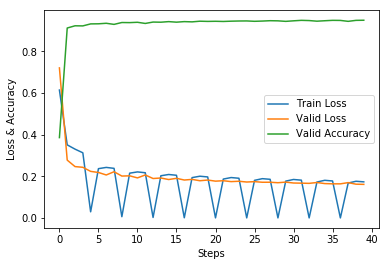

In [10]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [107]:
# 保存、提取模型（为展示用）
#torch.save(model,'bow.mdl')
#model = torch.load('bow.mdl')

In [14]:
#在测试集上分批运行，并计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for data, target in zip(test_data, test_label):
    data, target = Variable(torch.FloatTensor(data).view(1,-1)), Variable(torch.LongTensor(np.array([target])))
    output = model(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0] / rights[1]
right_rate

0.9009976976208749

### 4. 解剖神经网络

接下来，我们对训练好的神经网络进行解剖分析。

我们看一看每一个神经元都在检测什么模式；

我们也希望看到神经网络在测试集上判断错误的数据上出错的原因

#### 1). 查看每一层的模式

In [17]:
# 将神经网络的架构打印出来，方便后面的访问
model.named_parameters

<bound method Module.named_parameters of Sequential (
  (0): Linear (7139 -> 10)
  (1): ReLU ()
  (2): Linear (10 -> 2)
  (3): LogSoftmax ()
)>

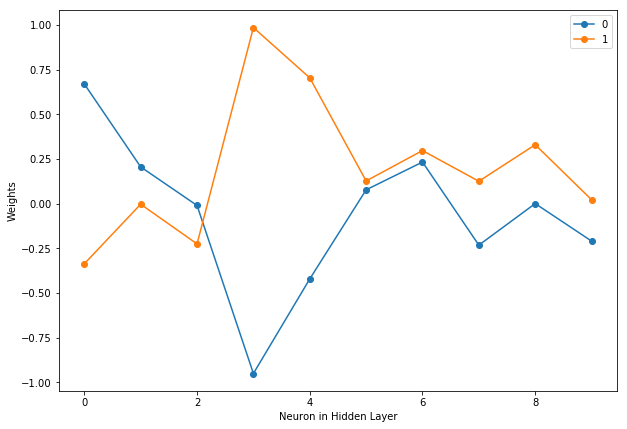

In [108]:
# 绘制出第二个全链接层的权重大小
# model[2]即提取第2层，网络一共4层，第0层为线性神经元，第1层为ReLU，第2层为第二层神经原链接，第3层为logsoftmax
plt.figure(figsize = (10, 7))
for i in range(model[2].weight.size()[0]):
    #if i == 1:
        weights = model[2].weight[i].data.numpy()
        plt.plot(weights, 'o-', label = i)
plt.legend()
plt.xlabel('Neuron in Hidden Layer')
plt.ylabel('Weights')

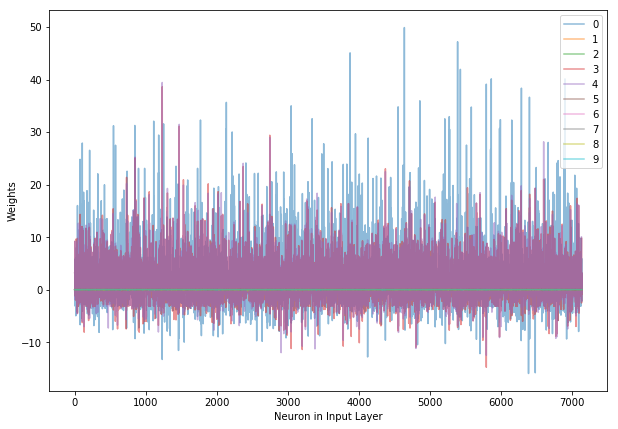

In [109]:
# 将第一层神经元的权重都打印出来，一条曲线表示一个隐含层神经元。横坐标为输入层神经元编号，纵坐标为权重值大小
plt.figure(figsize = (10, 7))
for i in range(model[0].weight.size()[0]):
    #if i == 1:
        weights = model[0].weight[i].data.numpy()
        plt.plot(weights, alpha = 0.5, label = i)
plt.legend()
plt.xlabel('Neuron in Input Layer')
plt.ylabel('Weights')

In [110]:
# 将第二层的各个神经元与输入层的链接权重，挑出来最大的权重和最小的权重，并考察每一个权重所对应的单词是什么，把单词打印出来
# model[0]是取出第一层的神经元

for i in range(len(model[0].weight)):
    print('\n')
    print('第{}个神经元'.format(i))
    print('max:')
    st = sorted([(w,i) for i,w in enumerate(model[0].weight[i].data.numpy())])
    for i in range(20):
        word = index2word(st[-i][1],diction)
        print(word)
    print('min:')
    for i in range(20):
        word = index2word(st[i][1],diction)
        print(word)




第0个神经元
max:
垃圾
相当
耐心
划算
YY
nbsp
期望值
完全一致
quot
棒棒
超出
老朋友
超值
放心
亲身
试
款
努力
仔细
我用
min:
垃圾
差评
退
差
差劲
不好
无语
难看
承担
最差
我要
很差
发错
一星
半个
千万别
坑人
地摊货
不想
一股


第1个神经元
max:
快快乐乐
真
味道
这鞋
有没有
差劲
买
没有
老大
还
骗人
他
说
问
鳄鱼
含
妥妥
最坑
狂爱
茄色
min:
快快乐乐
健健康康
很
包装
也
～
拼
好
还来
仔细
amp
描述
支持
这次
网购
一定
不容
真的
一样
发货


第2个神经元
max:
说
距
锁边
简直
先是
白白净净
好几个
穿得酷
麻花
发财
别看
很窄
嗎
员太度
衣衣
一货
物流配送
体重
拒收
唯一
min:
说
有没有
买
骗人
啦
味道
老大
还
问
这鞋
的
没有
他
差劲
真
大力
方
物理
心急
同样


第3个神经元
max:
完全一致
退
地摊货
找
坑人
别
发错
丢
严重
要死
却
没收
破
差评
很差
一股
不如
骗人
千万别
差劲
min:
完全一致
谢谢
超值
力
没得说
试试
精细
惊喜
老公
广西南宁
很漂亮
还会来
昨天
物有所值
抱
还行
放心
没话说
合脚
试


第4个神经元
max:
完全一致
退
地摊货
找
严重
坑人
别
发错
丢
要死
很差
却
差评
骗人
差劲
签收
没收
竟然
一股
不如
min:
完全一致
不错
很棒
力
谢谢
没得说
广西南宁
惊喜
精细
昨天
实惠
很漂亮
舒适
漂亮
超值
挺不错
托
试试
刚好
物超所值


第5个神经元
max:
包装
邮寄
拉丝
Itisnotgood
费用
星星
分不多
稀饭
码须
时候
u
体恤
太肥
肯
趣味
皮好
眼瞎
显瘦
每周
剩
min:
包装
呢
速度
这次
宝贝
网购
店家
光顾
的
仔细
一定
快
服务
发货
很
描述
一样
支持
还来
也


第6个神经元
max:
有没有
超小
挺乱
断底
回來
相机
加呀
好久好久
字数
最好
粘胶
说句
那么
手一看
质量
脚耐折性
能
化学品
洞差
鬼刚
min:
有没有
还
说
差劲
这鞋
啦
的
他
味道
真
老大
买
没有
骗人
问
哄
╭
脱毛
温暖
绿色


第7个神经元
max:
折磨
蓝色


#### 2. 寻找判断错误的原因

In [111]:
# 收集到在测试集中判断错误的句子
wrong_sentences = []
targets = []
j = 0
sent_indices = []
for data, target in zip(test_data, test_label):
    predictions = model(Variable(torch.FloatTensor(data).view(1,-1)))
    pred = torch.max(predictions.data, 1)[1]
    target = torch.LongTensor(np.array([target])).view_as(pred)
    rights = pred.eq(target)
    indices = np.where(rights.numpy() == 0)[0]
    for i in indices:
        wrong_sentences.append(data)
        targets.append(target[i])
        sent_indices.append(test_size + j + i)
    j += len(target)

In [178]:
# 逐个查看出错的句子是什么
idx = 65
print(sentences[sent_indices[idx]], targets[idx].numpy()[0])
lst = list(np.where(wrong_sentences[idx]>0)[0])
mm = list(map(lambda x:index2word(x, diction), lst))
print(mm)

['面料', '不是', '很', '好', '样式', '还', '可以'] 1
['不是', '还', '好', '面料', '样式', '可以', '很']


In [179]:
# 观察第一层的权重与输入向量的内积结果，也就是对隐含层神经元的输入，其中最大数值对应的项就是被激活的神经元
# 负值最小的神经元就是被抑制的神经元
model[0].weight.data.numpy().dot(wrong_sentences[idx].reshape(-1, 1))

array([[  3.68143035e+00],
       [ -2.26595165e-02],
       [ -7.10971770e-03],
       [  2.42715367e-01],
       [  1.30977717e+00],
       [ -5.97434116e-03],
       [ -9.14752623e-03],
       [ -3.05731981e-02],
       [ -9.80353615e-04],
       [ -4.06029967e-04]])

In [180]:
# 显示输入句子的非零项，即对应单词不为空的项，看它们到隐含层指定神经元的权重是多少
model[0].weight[0].data.numpy()[np.where(wrong_sentences[idx]>0)[0]]

array([ 1.09417236, -0.34580594,  4.98125982,  3.20058918,  6.02985764,
        6.62689352,  4.18304586], dtype=float32)

## 三、RNN模型

我们分别比较了两种RNN模型，一个是普通的RNN模型，另一个是LSTM。

本单元的主要目的是了解RNN模型如何实现，以及考察它们在测试数据集上的分类准确度

### 1. 普通RNN模型

In [181]:
# 需要重新数据预处理，主要是要加上标点符号，它对于RNN起到重要作用
# 数据来源文件
good_file = 'data/good.txt'
bad_file  = 'data/bad.txt'
# 生成正样例和反样例，以及词典，很有趣的是，词典中的词语竟然比不考虑标点符号的时候少了（要知道标点也是被当作一个单词的），
# 主要原因应该是总的分词出来的数量变少了。当去掉标点符号以后，有很多字的组合被当作了单词处理了。
pos_sentences, neg_sentences, diction = Prepare_data(good_file, bad_file, False)

good.txt 包含 8089 行, 136364 个词.
bad.txt 包含 5076 行, 75669 个词.
字典大小：7024


In [182]:
# 重新准备数据，输入给RNN
# 与词袋模型不同的是。每一个句子在词袋模型中都被表示为了固定长度的向量，其中长度为字典的尺寸
# 在RNN中，每一个句子就是被单独当成词语的序列来处理的，因此序列的长度是与句子等长的

dataset = []
labels = []
sentences = []

# 正例集合
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            # 注意将每个词编码
            new_sentence.append(word2index(l, diction))
    #每一个句子都是一个不等长的整数序列
    dataset.append(new_sentence)
    labels.append(0)
    sentences.append(sentence)

# 反例集合
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(new_sentence)
    labels.append(1)
    sentences.append(sentence)

# 重新对数据洗牌，构造数据集合
indices = np.random.permutation(len(dataset))
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

test_size = len(dataset) // 10

# 训练集
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

# 校验集
valid_data = dataset[: test_size]
valid_label = labels[: test_size]

# 测试集
test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]


In [183]:
# 一个手动实现的RNN模型

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        # 一个embedding层
        self.embed = nn.Embedding(input_size, hidden_size)
        # 隐含层内部的相互链接
        self.i2h = nn.Linear(2 * hidden_size, hidden_size)
        # 隐含层到输出层的链接
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        
        # 先进行embedding层的计算，它可以把一个数或者数列，映射成一个向量或一组向量
        # input尺寸：seq_length, 1
        x = self.embed(input)
        # x尺寸：hidden_size
        
        # 将输入和隐含层的输出（hidden）耦合在一起构成了后续的输入
        combined = torch.cat((x, hidden), 1)
        # combined尺寸：2*hidden_size
        #
        # 从输入到隐含层的计算
        hidden = self.i2h(combined)
        # combined尺寸：hidden_size
        
        # 从隐含层到输出层的运算
        output = self.i2o(hidden)
        # output尺寸：output_size
        
        # softmax函数
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # 对隐含单元的初始化
        # 注意尺寸是：batch_size, hidden_size
        return Variable(torch.zeros(1, self.hidden_size))



In [184]:
# 开始训练这个RNN，10个隐含层单元
rnn = RNN(len(diction), 10, 2)

# 交叉熵评价函数
cost = torch.nn.NLLLoss()

# Adam优化器
optimizer = torch.optim.Adam(rnn.parameters(), lr = 0.0001)
records = []

# 学习周期10次
for epoch in range(10):
    losses = []
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        x = Variable(torch.LongTensor(x))
        #x尺寸：seq_length（序列的长度）
        y = Variable(torch.LongTensor(np.array([y])))
        #x尺寸：batch_size = 1,1
        optimizer.zero_grad()
        
        #初始化隐含层单元全为0
        hidden = rnn.initHidden()
        # hidden尺寸：batch_size = 1, hidden_size
        
        #手动实现RNN的时间步循环，x的长度就是总的循环时间步，因为要把x中的输入句子全部读取完毕
        for s in range(x.size()[0]):
            output, hidden = rnn(x[s], hidden)
        
        #校验函数
        loss = cost(output, y)
        losses.append(loss.data.numpy()[0])
        loss.backward()
        # 开始优化
        optimizer.step()
        if i % 3000 == 0:
            # 每间隔3000步来一次校验集上面的计算
            val_losses = []
            rights = []
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = Variable(torch.LongTensor(x))
                y = Variable(torch.LongTensor(np.array([y])))
                hidden = rnn.initHidden()
                for s in range(x.size()[0]):
                    output, hidden = rnn(x[s], hidden)
                right = rightness(output, y)
                rights.append(right)
                loss = cost(output, y)
                val_losses.append(loss.data.numpy()[0])
            # 计算准确度
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 测试损失：{:.2f}, 测试准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

第0轮，训练损失：0.51, 测试损失：0.78, 测试准确率: 0.40
第0轮，训练损失：0.68, 测试损失：0.67, 测试准确率: 0.60
第0轮，训练损失：0.66, 测试损失：0.66, 测试准确率: 0.61
第0轮，训练损失：0.65, 测试损失：0.64, 测试准确率: 0.65
第1轮，训练损失：1.49, 测试损失：0.64, 测试准确率: 0.65
第1轮，训练损失：0.62, 测试损失：0.62, 测试准确率: 0.66
第1轮，训练损失：0.60, 测试损失：0.59, 测试准确率: 0.68
第1轮，训练损失：0.58, 测试损失：0.52, 测试准确率: 0.74
第2轮，训练损失：1.09, 测试损失：0.51, 测试准确率: 0.75
第2轮，训练损失：0.49, 测试损失：0.49, 测试准确率: 0.77
第2轮，训练损失：0.46, 测试损失：0.47, 测试准确率: 0.78
第2轮，训练损失：0.46, 测试损失：0.45, 测试准确率: 0.79
第3轮，训练损失：0.56, 测试损失：0.45, 测试准确率: 0.80
第3轮，训练损失：0.44, 测试损失：0.44, 测试准确率: 0.81
第3轮，训练损失：0.41, 测试损失：0.43, 测试准确率: 0.81
第3轮，训练损失：0.41, 测试损失：0.42, 测试准确率: 0.82
第4轮，训练损失：0.41, 测试损失：0.42, 测试准确率: 0.82
第4轮，训练损失：0.40, 测试损失：0.41, 测试准确率: 0.82
第4轮，训练损失：0.38, 测试损失：0.41, 测试准确率: 0.83
第4轮，训练损失：0.38, 测试损失：0.40, 测试准确率: 0.83
第5轮，训练损失：0.33, 测试损失：0.40, 测试准确率: 0.83
第5轮，训练损失：0.38, 测试损失：0.39, 测试准确率: 0.83
第5轮，训练损失：0.36, 测试损失：0.40, 测试准确率: 0.84
第5轮，训练损失：0.36, 测试损失：0.38, 测试准确率: 0.84
第6轮，训练损失：0.28, 测试损失：0.38, 测试准确率: 0.85
第6轮，训练损失：0.37, 测试损失：0.38, 测试准确率: 0.84
第6轮，训练损失：0.3

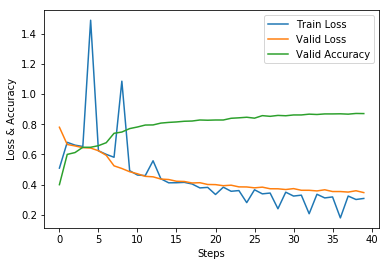

In [185]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [186]:
#在测试集上运行，并计算准确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for j, test in enumerate(zip(test_data, test_label)):
    x, y = test
    x = Variable(torch.LongTensor(x))
    y = Variable(torch.LongTensor(np.array([y])))
    hidden = rnn.initHidden()
    for s in range(x.size()[0]):
        output, hidden = rnn(x[s], hidden)
    right = rightness(output, y)
    rights.append(right)
    val = rightness(output, y) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0] / rights[1]
right_rate

0.8860182370820668

In [76]:
#保存、加载模型（为讲解用）
#torch.save(rnn, 'rnn.mdl')
#rnn = torch.load('rnn.mdl')

/Users/jake/anaconda/envs/learning_pytorch/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## LSTM网络

普通RNN的效果并不好，我们尝试利用改进型的RNN，即LSTM。LSTM与RNN最大的区别就是在于每个神经元中多增加了3个控制门：遗忘门、输入门和输出门. 另外，在每个隐含层神经元中，LSTM多了一个cell的状态，起到了记忆的作用。

这就使得LSTM可以记忆更长时间的Pattern

In [199]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(LSTMNetwork, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        # LSTM的构造如下：一个embedding层，将输入的任意一个单词映射为一个向量
        # 一个LSTM隐含层，共有hidden_size个LSTM神经元
        # 一个全链接层，外接一个softmax输出
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, 2)
        self.logsoftmax = nn.LogSoftmax()

    def forward(self, input, hidden=None):
        
        #input尺寸: seq_length
        #词向量嵌入
        embedded = self.embedding(input)
        #embedded尺寸: seq_length, hidden_size
        
        #PyTorch设计的LSTM层有一个特别别扭的地方是，输入张量的第一个维度需要是时间步，
        #第二个维度才是batch_size，所以需要对embedded变形
        embedded = embedded.view(input.data.size()[0], 1, self.hidden_size)
        #embedded尺寸: seq_length, batch_size = 1, hidden_size
    
        #调用PyTorch自带的LSTM层函数，注意有两个输入，一个是输入层的输入，另一个是隐含层自身的输入
        # 输出output是所有步的隐含神经元的输出结果，hidden是隐含层在最后一个时间步的状态。
        # 注意hidden是一个tuple，包含了最后时间步的隐含层神经元的输出，以及每一个隐含层神经元的cell的状态
        
        output, hidden = self.lstm(embedded, hidden)
        #output尺寸: seq_length, batch_size = 1, hidden_size
        #hidden尺寸: 二元组(n_layer = 1 * batch_size = 1 * hidden_size, n_layer = 1 * batch_size = 1 * hidden_size)
        
        #我们要把最后一个时间步的隐含神经元输出结果拿出来，送给全连接层
        output = output[-1,...]
        #output尺寸: batch_size = 1, hidden_size

        #全链接层
        out = self.fc(output)
        #out尺寸: batch_size = 1, output_size
        # softmax
        out = self.logsoftmax(out)
        return out

    def initHidden(self):
        # 对隐单元的初始化
        
        # 对隐单元输出的初始化，全0.
        # 注意hidden和cell的维度都是layers,batch_size,hidden_size
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        # 对隐单元内部的状态cell的初始化，全0
        cell = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        return (hidden, cell)



In [200]:
# 开始训练LSTM网络

# 构造一个LSTM网络的实例
lstm = LSTMNetwork(len(diction), 10, 2)

#定义损失函数
cost = torch.nn.NLLLoss()

#定义优化器
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001)
records = []

# 开始训练，一共5个epoch，否则容易过拟合
for epoch in range(5):
    losses = []
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        x = Variable(torch.LongTensor(x))
        #x尺寸：seq_length，序列的长度
        y = Variable(torch.LongTensor(np.array([y])))
        #y尺寸：batch_size = 1, 1
        optimizer.zero_grad()
        
        #初始化LSTM隐含层单元的状态
        hidden = lstm.initHidden()
        #hidden: 二元组(n_layer = 1 * batch_size = 1 * hidden_size, n_layer = 1 * batch_size = 1 * hidden_size)
        
        #让LSTM开始做运算，注意，不需要手工编写对时间步的循环，而是直接交给PyTorch的LSTM层。
        #它自动会根据数据的维度计算若干时间步
        output = lstm(x, hidden)
        #output尺寸: batch_size = 1, output_size
        
        #损失函数
        loss = cost(output, y)
        losses.append(loss.data.numpy()[0])
        
        #反向传播
        loss.backward()
        optimizer.step()
        
        #每隔3000步，跑一次校验集，并打印结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = Variable(torch.LongTensor(x))
                y = Variable(torch.LongTensor(np.array([y])))
                hidden = lstm.initHidden()
                output = lstm(x, hidden)
                #计算校验数据集上的分类准确度
                right = rightness(output, y)
                rights.append(right)
                loss = cost(output, y)
                val_losses.append(loss.data.numpy()[0])
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 测试损失：{:.2f}, 测试准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

第0轮，训练损失：0.51, 测试损失：0.76, 测试准确率: 0.40
第0轮，训练损失：0.51, 测试损失：0.44, 测试准确率: 0.81
第0轮，训练损失：0.42, 测试损失：0.39, 测试准确率: 0.84
第0轮，训练损失：0.39, 测试损失：0.37, 测试准确率: 0.86
第1轮，训练损失：0.12, 测试损失：0.35, 测试准确率: 0.87
第1轮，训练损失：0.30, 测试损失：0.35, 测试准确率: 0.87
第1轮，训练损失：0.28, 测试损失：0.34, 测试准确率: 0.87
第1轮，训练损失：0.28, 测试损失：0.33, 测试准确率: 0.88
第2轮，训练损失：0.05, 测试损失：0.33, 测试准确率: 0.88
第2轮，训练损失：0.26, 测试损失：0.33, 测试准确率: 0.88
第2轮，训练损失：0.25, 测试损失：0.33, 测试准确率: 0.88
第2轮，训练损失：0.25, 测试损失：0.33, 测试准确率: 0.89
第3轮，训练损失：0.04, 测试损失：0.32, 测试准确率: 0.89
第3轮，训练损失：0.24, 测试损失：0.33, 测试准确率: 0.89
第3轮，训练损失：0.23, 测试损失：0.32, 测试准确率: 0.88
第3轮，训练损失：0.23, 测试损失：0.32, 测试准确率: 0.89
第4轮，训练损失：0.04, 测试损失：0.32, 测试准确率: 0.89
第4轮，训练损失：0.22, 测试损失：0.33, 测试准确率: 0.88
第4轮，训练损失：0.21, 测试损失：0.33, 测试准确率: 0.89
第4轮，训练损失：0.21, 测试损失：0.33, 测试准确率: 0.89


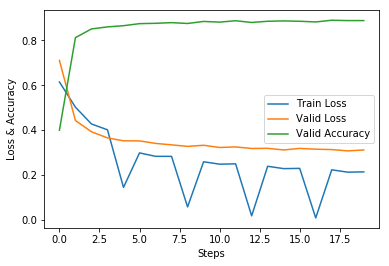

In [197]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [198]:
#在测试集上计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for j, test in enumerate(zip(test_data, test_label)):
    x, y = test
    x = Variable(torch.LongTensor(x))
    y = Variable(torch.LongTensor(np.array([y])))
    hidden = lstm.initHidden()
    output = lstm(x, hidden)
    right = rightness(output, y)
    rights.append(right)
    val = rightness(output, y) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0] / rights[1]
right_rate

0.9019756838905775

In [99]:
#保存、加载模型（为讲解用）
#torch.save(lstm, 'lstm.mdl')
#rnn = torch.load('rnn.mdl')

/Users/jake/anaconda/envs/learning_pytorch/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type LSTMNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码